**Project: Machine Learning Spam Classifier**

*A Machine Learning application that predicts whether an email is spam or not*

# 1. Background and Theory

**1. What is Machine Learning?**

Machine Learning is a scientific discipline that focuses on developing algorithms that allow computers to evolve behaviors based on empirical data. In simpler terms, it's about building systems that can learn from data. Unlike traditional algorithms, where explicit instructions are given for every task, machine learning algorithms use data to refine their operations. Essentially, the system's learning means improving at a task over time, given a specific performance measure.

**2. When is Machine Learning Useful?**

Machine Learning is particularly valuable in situations where:

*   We face problems too complex to be solved with traditional or algorithmic approaches.
*   Hand-tuning of rules and parameters is infeasible because of the vast complexity.
*   The environment in which the system operates fluctuates or evolves, necessitating the system to adapt over time.
*   Insights need to be derived from large amounts of data (data mining).

**3. What's the Role of Data in Machine Learning?**

Data plays a pivotal role in training machine learning systems. A **labeled training set** provides both the input data and the desired solution (label) for each instance. This set serves as the ground truth for supervised learning tasks.

**4. Types of Common Supervised Tasks:**

*   **Regression:** Here, the objective is to predict a continuous value. For example, predicting the price of a house based on its features.
*   **Classification:** In this task, the goal is to predict a class label. For instance, determining whether an email is spam or not.

**5. Model-based Learning:**

In model-based learning, the objective is to determine the optimal parameters for a model such that it can make accurate predictions on new, unseen data. These algorithms seek an optimal value for model parameters so they generalize well. They often involve a cost function, which quantifies how wrong the model's predictions are. A good model strikes a balance between fitting the data well (low bias) and not being overly complex (low variance).

**6. Challenges in Machine Learning:**

Machine Learning isn't magic. It's only as good as the data and the way we use it. Some challenges practitioners face are:

*   **Insufficient Quantity of Data:** More data often leads to better models. But gathering data can be time-consuming and expensive.
*   **Poor Data Quality:** Noisy, erroneous, or inconsistent data can drastically degrade the model's performance.
*   **Non-representative Data:** For generalization, it's essential to have data that represents all classes and scenarios the model will face in the real world.
*   **Irrelevant Features:** A model's performance is heavily dependent on the input features. Irrelevant or redundant features can obscure the important ones.
*   **Overfitting:** When a model performs exceedingly well on training data but poorly on unseen data, it might be capturing noise rather than underlying patterns.
*   **Underfitting:** On the contrary, when a model is too simple to capture the underlying structure of the data, it may underfit.

**7. Ensuring Generalization:**

For a model to be valuable, it needs to generalize well to new, unseen instances. One common way to assess generalization is to use a **test set**—a subset of the data not used during training. This set can provide an estimate of the model's performance in real-world scenarios.

# 2. Data Loading and Exploration
Before any machine learning tasks, we must acquire and understand the data. This step ensures that we have the right quality and quantity of data.

The data is fetched from URLs containing spam and ham (non-spam) datasets.

In [1]:
import os
from pathlib import Path
import tarfile
import urllib.request

BASE_URL = "http://spamassassin.apache.org/old/publiccorpus/"
SAVE_PATH = Path("datasets/spam")

DATA_SOURCES = {
    "easy_ham": {"url_suffix": "20030228_easy_ham.tar.bz2"},
    "easy_ham_2": {"url_suffix": "20030228_easy_ham_2.tar.bz2"},
    "hard_ham": {"url_suffix": "20030228_hard_ham.tar.bz2"},
    "spam": {"url_suffix": "20030228_spam.tar.bz2"},
    "spam_2": {"url_suffix": "20050311_spam_2.tar.bz2"},
}

def ensure_directory_exists(directory):
    if not directory.exists():
        directory.mkdir(parents=True, exist_ok=True)

def download_and_extract(dataset_name, url):
    archive_path = SAVE_PATH / f"{dataset_name}.tar.bz2"

    if not (SAVE_PATH / dataset_name).exists():
        print(f"Fetching {archive_path}...")
        urllib.request.urlretrieve(url, archive_path)

        with tarfile.open(archive_path, "r") as archive_file:
            archive_file.extractall(SAVE_PATH)

def retrieve_data():
    ensure_directory_exists(SAVE_PATH)

    for name, data in DATA_SOURCES.items():
        full_url = os.path.join(BASE_URL, data["url_suffix"])
        download_and_extract(name, full_url)

def list_files_with_length_check(directory, length_check = 20):
    return [f for f in sorted(directory.iterdir()) if len(f.name) > length_check]

def fetch_spam_data():
    retrieve_data()

    ham_files = list_files_with_length_check(SAVE_PATH / "easy_ham") + \
                list_files_with_length_check(SAVE_PATH / "easy_ham_2") + \
                list_files_with_length_check(SAVE_PATH / "hard_ham")

    spam_files = list_files_with_length_check(SAVE_PATH / "spam") + \
                 list_files_with_length_check(SAVE_PATH / "spam_2")

    return ham_files, spam_files


ham_filenames, spam_filenames = fetch_spam_data()
print(f"{len(ham_filenames)} ham samples retrieved")
print(f"{len(spam_filenames)} spam samples retrieved")

4150 ham samples retrieved
1896 spam samples retrieved


By observing a few examples of the data (both ham and spam), we can gain insights into potential patterns or differences between the two categories.

In [2]:
import email
from email import policy, parser

def fetch_email_content(email_path):
    with email_path.open("rb") as file:
        return parser.BytesParser(policy=policy.default).parse(file)

def find_html_email(emails):
    for mail in emails:
        if mail.get_content_type() == "text/html":
            return mail
    return None

ham_email_contents = [fetch_email_content(path) for path in ham_filenames]
spam_email_contents = [fetch_email_content(path) for path in spam_filenames]

print("Ham email:\n", ham_email_contents[42].get_content().strip()[:200], "...\n")
print("Spam email:\n", spam_email_contents[42].get_content().strip()[:200], "...")

Ham email:
 < >
> I downloaded a driver from the nVidia website and installed it using RPM.
> Then I ran Sax2 (as was recommended in some postings I found on the net),
but
> it still doesn't feature my video card ...

Spam email:
 Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent i ...


Emails are complex structures with headers, body content (which can be in plain text or HTML), and sometimes attachments. Understanding this structure helps in preprocessing and feature extraction.

In [3]:
from typing import Union
from collections import Counter

def email_content_structure(mail):
    if isinstance(mail, str):
        return mail

    content = mail.get_payload()

    if isinstance(content, list):
        return "multipart({})".format(", ".join(email_content_structure(sub) for sub in content))

    return mail.get_content_type()

def count_email_structures(email_list):
    return Counter(email_content_structure(mail) for mail in email_list)

ham_structures = count_email_structures(ham_email_contents)
spam_structures = count_email_structures(spam_email_contents)

print("\n".join([str(t) for t in ham_structures.most_common()]), end="\n\n")
print("\n".join([str(t) for t in spam_structures.most_common()]))

('text/plain', 3832)
('text/html', 120)
('multipart(text/plain, application/pgp-signature)', 101)
('multipart(text/plain, text/html)', 63)
('multipart(text/plain, text/plain)', 5)
('multipart(text/plain)', 3)
('multipart(text/plain, application/ms-tnef, text/plain)', 2)
('multipart(text/plain, application/octet-stream)', 2)
('multipart(text/plain, multipart(text/plain))', 2)
('multipart(text/plain, application/x-pkcs7-signature)', 2)
('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)', 2)
('multipart(text/html)', 2)
('multipart(text/plain, text/enriched)', 1)
('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)', 1)
('multipart(text/plain, video/mng)', 1)
('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))', 1)
('multipart(text/plain, application/x-java-applet)', 1)
('multipart(text/plain, application/x-patch)', 1)
('multipart(multipart(text/plain, multi

# 3. Data Preprocessing

Raw data often isn't in a format that's immediately ready for machine learning algorithms. Preprocessing prepares this data, making it suitable for feeding into models.

Many emails are in HTML format. However, ML models require numerical or categorical data. Hence, HTML emails are converted to plain text. This step simplifies the data without losing essential information.

In [4]:
from bs4 import BeautifulSoup

def html_to_plain_text(raw_html):
    soup = BeautifulSoup(raw_html, 'html.parser')
    for script in soup(["script", "style"]):
        script.extract()
    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines())
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    cleaned_text = '\n'.join(chunk for chunk in chunks if chunk)
    return cleaned_text

def extract_text_from_email(mail):
    html_content = None

    for part in mail.walk():
        content_type = part.get_content_type()

        if content_type not in ["text/plain", "text/html"]:
            continue

        try:
            content_data = part.get_content()
        except Exception:
            content_data = str(part.get_payload())

        if content_type == "text/plain":
            return content_data
        elif content_type == "text/html":
            html_content = content_data

    if html_content:
        return html_to_plain_text(html_content)

example_html_spam = find_html_email(spam_email_contents)
print(extract_text_from_email(example_html_spam)[:200], "...")

Save up to 70% on Life Insurance.
Why Spend More Than You Have To?
Life Quote Savings
Ensuring your
family's financial security is very important. Life Quote Savings makes
buying life insurance simple ...


Real-world data is often noisy. By introducing typos, we simulate this noise, potentially improving the model's robustness. This mirrors the concept of data augmentation, a technique where training data is artificially augmented to improve model generalization.

Text data is tokenized and then transformed into a numerical format using Term Frequency-Inverse Document Frequency (TF-IDF). TF-IDF is a statistical measure that evaluates the importance of a word in a document relative to a collection of documents. It gives more weight to terms that are more significant to a particular document and less weight to terms that are common across all documents.

In [5]:
%pip install urlextract

import nltk
import random
import urlextract

stemmer = nltk.PorterStemmer()
url_extractor = urlextract.URLExtract()

def introduce_typos(text, typo_chance=0.02):
    typos = {
        'a': 'q', 's': 'w', 'z': 'x', 'c': 'x', 'n': 'b', 'm': 'n',
    }
    return ''.join([typos[char] if char in typos and random.random() < typo_chance else char for char in text])

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import re

class EmailTypoIntroducer(BaseEstimator, TransformerMixin):
    def __init__(self, typo_chance=0.02):
        self.typo_chance = typo_chance

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [introduce_typos(email, self.typo_chance) for email in X]
from sklearn.pipeline import Pipeline

class EmailToTfidfTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        self.vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)

    def _preprocess_emails(self, X):
        X_transformed = []
        for email in X:
            text = email or ""
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.stemming and stemmer is not None:
                text = " ".join([stemmer.stem(word) for word in text.split()])
            X_transformed.append(text)
        return X_transformed

    def fit(self, X, y=None):
        X_transformed = self._preprocess_emails(X)
        self.vectorizer.fit(X_transformed)
        return self

    def transform(self, X, y=None):
        X_transformed = self._preprocess_emails(X)
        return self.vectorizer.transform(X_transformed)

# 4. Building the models
Once the data is prepared, we train various classifiers to distinguish between spam and ham emails.

**Train-Test Split**: Ensures we have separate data for training and validating the model. This separation helps in evaluating the model's performance on unseen data, providing an estimate of its real-world performance.

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X = np.array(ham_email_contents + spam_email_contents, dtype=object)
y = np.array([0] * len(ham_email_contents) + [1] * len(spam_email_contents))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocess_pipeline = Pipeline([
    ("typo_introducer", EmailTypoIntroducer()),
    ("email_to_tfidf", EmailToTfidfTransformer())
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)
X_test_transformed = preprocess_pipeline.transform(X_test)

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, expon, randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

**KNN (K-Nearest Neighbors)**: A non-parametric method that classifies a sample based on the majority class of its 'k' nearest samples in the training set. The notion of 'distance' (often Euclidean) determines 'nearness'.

In [8]:
knn_clf_email = KNeighborsClassifier()
param_grid_knn = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
grid_search_knn = GridSearchCV(knn_clf_email, param_grid_knn, cv=5)
grid_search_knn.fit(X_train_transformed, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}])

**SVM (Support Vector Machines)**: A powerful classifier that works by finding a hyperplane that best separates the classes of data. It's especially effective in high-dimensional spaces.

In [9]:
param_grid_svc = [
    {'kernel': ['linear'], 'C': loguniform(1, 10)},
    {'kernel': ['rbf'], 'C': loguniform(1, 10), 'gamma': expon(scale=1.0)},
]

svc_clf = SVC(class_weight='balanced')
rnd_search_svc = RandomizedSearchCV(svc_clf, param_distributions=param_grid_svc, n_iter=50, cv=5)
rnd_search_svc.fit(X_train_transformed, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_iter=50,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x780725df2740>,
                                         'kernel': ['linear']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x780725df2a40>,
                                         'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x780725df2800>,
                                         'kernel': ['rbf']}])

**Random Forest**: An ensemble method that builds multiple decision trees and merges their outputs for improved accuracy and robustness against overfitting.

In [10]:
param_distribs_rf = {
    'n_estimators': randint(low=10, high=200),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': randint(low=1, high=40),
    'min_samples_split': randint(low=2, high=40),
    'min_samples_leaf': randint(low=1, high=40),
    'bootstrap': [True, False]
}

forest_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
rnd_search_rf = RandomizedSearchCV(forest_clf, param_distributions=param_distribs_rf,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
rnd_search_rf.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x780725df2980>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x780725f824a0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x780725df3970>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x78075ae46cb0>},
                   random_state=42, verbose=2)

**Logistic Regression**: Despite its name, it's a binary classification algorithm. It estimates the probability that a given instance belongs to a particular category.

In [11]:
param_distribs_log = {
    'C': loguniform(1e-3, 1e3),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}


log_clf = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
rnd_search_log = RandomizedSearchCV(log_clf, param_distributions=param_distribs_log,
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
rnd_search_log.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(class_weight='balanced',
                                                max_iter=1000,
                                                random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x780725df3df0>,
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=42, verbose=2)

Using precision (how many selected items are relevant), recall (how many relevant items are selected), and the F1 score (harmonic mean of precision and recall), we evaluate each model's performance. These metrics provide a holistic view of a model's ability to correctly classify spam and ham emails without producing too many false positives or negatives.

[{'name': 'KNN', 'precision': 0.9859154929577465, 'recall': 0.9695290858725761, 'f1': 0.9776536312849161}, {'name': 'SVM', 'precision': 0.9887323943661972, 'recall': 0.9722991689750693, 'f1': 0.9804469273743017}, {'name': 'Random Forest', 'precision': 0.9407008086253369, 'recall': 0.9667590027700831, 'f1': 0.953551912568306}, {'name': 'Logistic Regression', 'precision': 0.9831460674157303, 'recall': 0.9695290858725761, 'f1': 0.9762900976290098}]


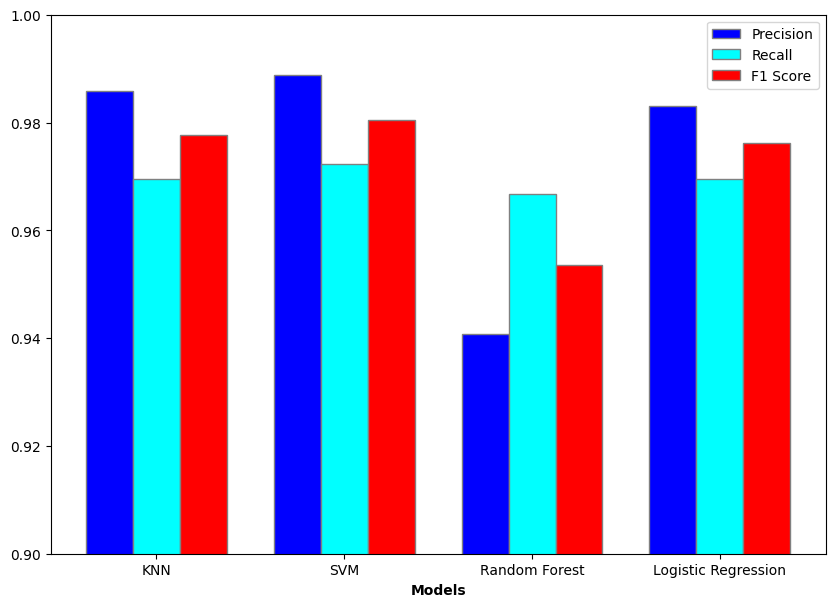

In [12]:
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {"name": model_name, "precision": precision, "recall": recall, "f1": f1}

models = [grid_search_knn, rnd_search_svc, rnd_search_rf, rnd_search_log]
model_names = ["KNN", "SVM", "Random Forest", "Logistic Regression"]

results = [evaluate_model(model, X_test_transformed, y_test, name) for model, name in zip(models, model_names)]

print(results)

names = [res["name"] for res in results]
precisions = [res["precision"] for res in results]
recalls = [res["recall"] for res in results]
f1_scores = [res["f1"] for res in results]

barWidth = 0.25
r1 = range(len(precisions))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.figure(figsize=(10, 7))
plt.bar(r1, precisions, color='blue', width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r2, recalls, color='cyan', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, f1_scores, color='red', width=barWidth, edgecolor='grey', label='F1 Score')

plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(precisions))], names)

plt.ylim([0.90, 1.0])

plt.legend()
plt.show()

# 5. Conclusions

In our effort to create an effective spam filter, we've looked at how well four different methods work at catching spam emails. Remember, in our tests, spam emails are what we're calling the "positive" results. Here's what we found:

1. **K-Nearest Neighbors (KNN)**:
    - Precision: 98.59%
    - Recall: 96.95%
    - F1 Score: 97.77%
    
    KNN’s high precision means that when it flags an email as spam, there's a 98.59% chance that it's a genuine spam email. This reduces the risk of legitimate emails being mistakenly directed to the spam folder, which is critical for user satisfaction. Its strong recall suggests that it can identify nearly 97% of all spam emails, so users can be reasonably assured that most spam won't land in their main inbox.

2. **Support Vector Machines (SVM)**:
    - Precision: 98.87%
    - Recall: 97.23%
    - F1 Score: 98.04%
    
    SVM, with the highest precision among the models, minimizes the risk of "false positives" the most. In other words, the chance of a real, important email being mistakenly classified as spam is minimal. Its robust recall also implies that it's very effective at capturing spam emails, providing a nearly clutter-free inbox for users.

3. **Random Forest**:
    - Precision: 94.07%
    - Recall: 96.68%
    - F1 Score: 95.36%
    
    Random Forest, although robust, presents a slightly reduced precision. This implies a slightly increased risk that genuine emails might be flagged as spam. However, its high recall underscores its ability to trap a significant majority of spam emails. In spam detection, while precision is crucial to prevent user frustration, a high recall is also essential to maintain the integrity of a user's primary inbox.

4. **Logistic Regression**:
    - Precision: 98.31%
    - Recall: 96.95%
    - F1 Score: 97.63%
    
    Logistic Regression performs comparably to KNN, ensuring that legitimate emails are predominantly left untouched while effectively filtering out spam. Its balanced performance might make it an attractive choice for situations where both false positives and false negatives have considerable impact.

**Overall Observations**:
- Given the nature of spam classification, precision is a critical metric. Users can be particularly frustrated if genuine emails are classified as spam, potentially leading to missed opportunities or important information. In this regard, SVM emerges as the strongest contender.
- However, the goal of a spam filter is also to prevent as many spam emails as possible from reaching the main inbox. Here, recall becomes vital, and models like KNN and SVM which maintain high recall rates are advantageous.
- Considering the implications of missed spam (recall) and misclassified genuine emails (precision), the F1 score, which harmoniously balances these two metrics, is essential. Here again, SVM takes the lead, closely followed by KNN and Logistic Regression.
- The slightly lower performance of Random Forest might suggest the need for more fine-tuning or that tree-based approaches might not be the optimal fit for this particular spam classification task.

To conclude, building a spam classifier demands a nuanced balance between ensuring genuine emails are not misclassified while effectively filtering out unwanted spam. In our evaluations, SVM emerges as the most suitable candidate, but the final choice should be made considering other factors like computation resources, interpretability, and scalability, ensuring the model meets all business and user needs.